# Procesamiento de Imágenes.
Nisrine Fariss Lamine, Diego Vallina Álvarez, Pablo Fuentes de Mateo, Raúl Ortega Renuncio


## Índice

### 1. FISH: Conteo de sondas por célula y clasificación (**Baseline**)

- 1.1 Objetivo del trabajo  
- 1.2 Inspección y comprensión del dataset  
- 1.3 Separación de canales  
- 1.4 Preprocesado de la imagen  
- 1.5 Detección de sondas fluorescentes  
- 1.6 Uso de máscaras reales y asignación de sondas a células  
- 1.7 Clasificación celular  
- 1.8 Resultados por imagen  
- 1.9 Análisis global del dataset  
- 1.10 Resultados finales en células válidas  

---

### 2. Mejora del método: segmentación automática con **U-Net**

- 2.1 Motivación de la mejora  
- 2.2 Preparación de los datos para segmentación semántica  
- 2.3 División del dataset y estrategia de entrenamiento  
- 2.4 Arquitectura del modelo **U-Net**  
- 2.5 Función de pérdida y métricas de evaluación  
- 2.6 Entrenamiento del modelo  
- 2.7 Evolución de las métricas de entrenamiento y validación  
- 2.8 Ejemplo visual de segmentación predicha  
- 2.9 Conversión de máscara binaria a instancias (*watershed*)  
- 2.10 Inferencia en imagen completa mediante *tiling*  
- 2.11 Conteo de sondas y clasificación usando segmentación automática  
- 2.12 Comparación de resultados: **Baseline vs U-Net**  

---

### 3. Mejora adicional: refinamiento de instancias segmentadas

- 3.1 Motivación del refinamiento  
- 3.2 Estrategia de refinamiento basada en criterios geométricos  
- 3.3 Filtrado de instancias por área  
- 3.4 Pipeline completo con refinamiento  
- 3.5 Resultados del refinamiento y análisis de su impacto  
- 3.6 Comparación de métodos: **Baseline, U-Net y U-Net refinado**  

---

### 4. Conclusiones


# FISH: Conteo de sondas por célula + clasificación (baseline con máscaras)

## Objetivo
Usar las máscaras (`imgs/labels/`) para separar células y, dentro de cada célula, detectar y contar:
- Sondas **rojas** (gen de interés)
- Sondas **verdes/azules** (control)

Con esos conteos, clasificar cada célula en:
- **Normal**: 2 control + 2 gen
- **Deleción 1 brazo**: 2 control + 1 gen
- **Deleción 2 brazos**: 2 control + 0 gen

Salida final por imagen:
- Conteo de células por clase
- Porcentaje por clase
- Visualización overlay (puntos detectados + máscara)


In [49]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

from skimage import io, exposure
from skimage.filters import gaussian, threshold_otsu, threshold_local
from skimage.morphology import remove_small_objects, remove_small_holes, disk, opening, closing
from skimage.measure import label, regionprops
from skimage.feature import blob_log
from skimage.segmentation import find_boundaries

plt.rcParams["figure.figsize"] = (8, 8)


## Rutas
Definimos la carpeta raíz del proyecto y localizamos:
- Imágenes TIFF (`imgs/tiff/`)
- Labels por célula (`imgs/labels/`)


In [50]:
from pathlib import Path

# Nueva raíz correcta
ROOT = Path(r"C:\Users\Nisrin Fariss Lamine\Downloads\trabajo25_26UNet\trabajo25_26UNet")

IMG_DIR = ROOT / "imgs" / "tiff"
LBL_DIR = ROOT / "imgs" / "labels"

print("IMG_DIR =", IMG_DIR)
print("LBL_DIR =", LBL_DIR)

assert IMG_DIR.exists(), f"No encontrado {IMG_DIR}"
assert LBL_DIR.exists(), f"No encontrado {LBL_DIR}"

img_files = sorted(list(IMG_DIR.glob("*.tif*")))
lbl_files = sorted(list(LBL_DIR.glob("*.tif*")))

len(img_files), len(lbl_files), img_files[:3], lbl_files[:3]


IMG_DIR = C:\Users\Nisrin Fariss Lamine\Downloads\trabajo25_26UNet\trabajo25_26UNet\imgs\tiff
LBL_DIR = C:\Users\Nisrin Fariss Lamine\Downloads\trabajo25_26UNet\trabajo25_26UNet\imgs\labels


(25,
 25,
 [WindowsPath('C:/Users/Nisrin Fariss Lamine/Downloads/trabajo25_26UNet/trabajo25_26UNet/imgs/tiff/cell_00001.tiff'),
  WindowsPath('C:/Users/Nisrin Fariss Lamine/Downloads/trabajo25_26UNet/trabajo25_26UNet/imgs/tiff/cell_00002.tiff'),
  WindowsPath('C:/Users/Nisrin Fariss Lamine/Downloads/trabajo25_26UNet/trabajo25_26UNet/imgs/tiff/cell_00003.tiff')],
 [WindowsPath('C:/Users/Nisrin Fariss Lamine/Downloads/trabajo25_26UNet/trabajo25_26UNet/imgs/labels/cell_00001.label.tiff'),
  WindowsPath('C:/Users/Nisrin Fariss Lamine/Downloads/trabajo25_26UNet/trabajo25_26UNet/imgs/labels/cell_00002.label.tiff'),
  WindowsPath('C:/Users/Nisrin Fariss Lamine/Downloads/trabajo25_26UNet/trabajo25_26UNet/imgs/labels/cell_00003.label.tiff')])

## Visualización de un ejemplo (imagen + máscara + bordes)
Comprobamos:
- Forma/dtype de la imagen (RGB o no)
- Que el label tenga muchas instancias (células con IDs distintos)
- Overlay de bordes para ver si coincide con células


IMG: cell_00001.tiff shape: (1040, 1392, 3) dtype: uint8
LBL: cell_00001.label.tiff shape: (1040, 1392, 3) dtype: uint8
Labels únicos: 256 (incluye 0=fondo si existe)
Min/Max label: 0 255


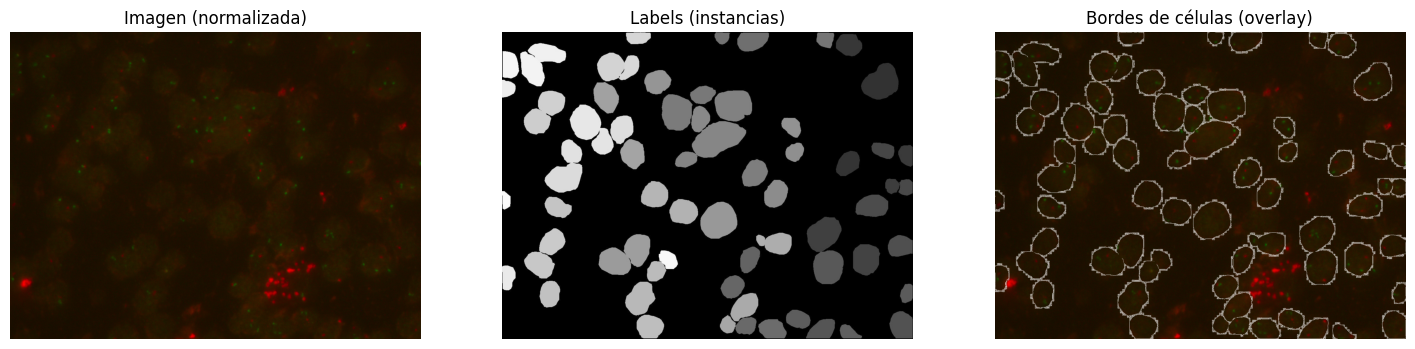

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage.segmentation import find_boundaries

def read_image(path):
    """Lee una imagen desde disco usando skimage.io.imread.

    Parámetros
    path:Ruta al archivo de imagen.

    Retorna
    np.ndarray:Imagen cargada como array NumPy.
    """
    return io.imread(str(path))

def normalize01(x):
    """
    Normaliza una imagen o array numérico al rango [0, 1].

    Esta función convierte la imagen a float32 y aplica una normalización min-max, lo cual es útil para preprocesado previo a análisis o redes neuronales

    Parámetros
    x : np.ndarray, imagen de entrada.

    Retorna
    np.ndarray, imagen normalizada en el rango [0, 1].
    """
    x = x.astype(np.float32)
    x = x - x.min()
    mx = x.max()
    if mx > 0:
        x = x / mx
    return x

def label_for_image(img_path):
    """
    Obtiene la ruta de la máscara (label) correspondiente a una imagen dada.

    Si no se encuentra el archivo esperado, se aplica un mecanismo de búsqueda alternativa como medida de seguridad.

    Parámetros
    img_path:Ruta a la imagen original.

    Retorna
     Ruta al archivo de máscara correspondiente.
     
    """
    lbl_name = img_path.name.replace(".tiff", ".label.tiff").replace(".tif", ".label.tif")
    lbl_path = LBL_DIR / lbl_name
    if not lbl_path.exists():
        # fallback por si hubiera alguna rareza
        base = img_path.stem
        candidates = list(LBL_DIR.glob(f"{base}*.tif*"))
        if len(candidates) == 0:
            raise FileNotFoundError(f"No encuentro label para {img_path.name}")
        lbl_path = candidates[0]
    return lbl_path

def show_example(idx=0):
    """
    Muestra un ejemplo completo de imagen FISH y su máscara asociada.

    La función visualiza:
    1. La imagen original normalizada
    2. La máscara de instancias celulares
    3. Un overlay con los bordes de las células
    Además, imprime información relevante sobre:
    - tamaño y tipo de datos de la imagen y la máscara
    - número de instancias celulares detectadas

    Parámetros
    idx : int, opcional 
    Índice de la imagen a mostrar dentro de la lista img_files.Por defecto es 0.
    """
    img_path = img_files[idx]
    lbl_path = label_for_image(img_path)

    img = read_image(img_path)
    lbl = read_image(lbl_path)

    print("IMG:", img_path.name, "shape:", img.shape, "dtype:", img.dtype)
    print("LBL:", lbl_path.name, "shape:", lbl.shape, "dtype:", lbl.dtype)

    uniq = np.unique(lbl)
    print("Labels únicos:", len(uniq), "(incluye 0=fondo si existe)")
    print("Min/Max label:", int(uniq.min()), int(uniq.max()))

    boundaries = find_boundaries(lbl > 0, mode="outer")

    fig, ax = plt.subplots(1, 3, figsize=(18, 6))

    if img.ndim == 3:
        ax[0].imshow(normalize01(img))
        ax[0].set_title("Imagen (normalizada)")
    else:
        ax[0].imshow(normalize01(img), cmap="gray")
        ax[0].set_title("Imagen (gris)")

    ax[1].imshow(lbl, cmap="nipy_spectral")
    ax[1].set_title("Labels (instancias)")

    if img.ndim == 3:
        overlay = normalize01(img).copy()
        overlay[boundaries] = 1.0
        ax[2].imshow(overlay)
        ax[2].set_title("Bordes de células (overlay)")
    else:
        ax[2].imshow(normalize01(img), cmap="gray")
        ax[2].imshow(boundaries, cmap="autumn", alpha=0.7)
        ax[2].set_title("Bordes (overlay)")

    for a in ax:
        a.axis("off")

    plt.show()

show_example(0)


## Inspección inicial de datos

La imagen original es una imagen RGB (3 canales) de alta resolución, en la que se observan múltiples células con señales fluorescentes. Los puntos brillantes corresponden a las sondas FISH:
- puntos **rojos**, asociados al gen de interés
- puntos **verde/azules**, que actúan como sondas de control

Las máscaras proporcionadas son de tipo *instance segmentation*: cada célula tiene un identificador distinto (valores enteros), lo que permite separar y analizar cada célula de forma individual sin necesidad de segmentarla automáticamente.

El overlay de los bordes de las máscaras sobre la imagen original muestra una buena correspondencia entre las regiones etiquetadas y las células visibles. Esto indica que las máscaras son fiables y pueden utilizarse directamente para asignar las sondas detectadas a cada célula.

Gracias a esto, el problema se simplifica: el reto principal no es segmentar las células, sino detectar y contar correctamente las sondas dentro de cada una.

## Selección de canales

A partir de la inspección visual de los canales RGB:
- El **canal rojo** corresponde al gen de interés.
- El **canal verde/azul** corresponde a las sondas de control.

Estos canales se procesarán de forma independiente para detectar los puntos fluorescentes.

In [4]:
RED_CH = 0      # gen de interés
CTRL_CH = 1     # sondas de control

def get_channels(img):
    """
    Extrae los canales correspondientes a las sondas del gen de interés y a las sondas de control a partir de una imagen multicanal

    Parámetros
    img : np.ndarray imagen de entrada multicanal.

    Retorna
    red : np.ndarray canal correspondiente a las sondas del gen de interés (rojo),convertido a tipo float32.
    ctrl : np.ndarray canal correspondiente a las sondas de control (verde/azul), convertido a tipo float32.
    """
    red = img[..., RED_CH].astype(np.float32)
    ctrl = img[..., CTRL_CH].astype(np.float32)
    return red, ctrl

## Preprocesado

Antes de detectar los puntos:
- Se suaviza ligeramente la imagen para reducir ruido.
- Se normaliza la intensidad.
- Se elimina parte del fondo para resaltar los spots brillantes.

El objetivo es facilitar la detección automática de puntos como blobs.

In [5]:
from skimage.filters import gaussian

def preprocess_channel(ch, sigma=1.0):
    """
    Aplica preprocesado a un canal de imagen FISH.

    Parámetros
    ch : np.ndarray canal de imagen de entrada (sondas de control o del gen de interés).
    sigma : float, opcional. Desviación estándar del filtro gaussiano. Valores mayores producen un mayor suavizado. Por defecto es 1.0.

    Retorna
    np.ndarra canal preprocesado, suavizado y normalizado en el rango [0, 1].

    
    """


    
    ch_smooth = gaussian(ch, sigma=sigma)
    ch_norm = normalize01(ch_smooth)
    return ch_norm


## Detección de sondas como coordenadas

Los puntos fluorescentes se modelan como blobs circulares brillantes.
Para detectarlos se utiliza el método Laplaciano de Gaussiana (LoG), que:
- localiza máximos locales
- estima el tamaño del spot
- devuelve coordenadas subpixel

Cada blob detectado se interpreta como una sonda.
La detección de sondas se realiza mediante técnicas clásicas basadas en:
- filtrado espacial
- umbralización
- identificación de máximos locales
  
Como resultado, se obtiene un conjunto de coordenadas que representan la posición de cada sonda detectada en la imagen.

In [47]:
from skimage.feature import blob_log

def detect_blobs(ch,min_sigma=1.5, max_sigma=4.0, num_sigma=6, threshold=0.03):
    """
    Detecta sondas fluorescentes en un canal de imagen mediante el método Laplaciano de Gaussiana (LoG).
    Esta técnica permite localizar puntos brillantes (blobs) que corresponden a sondas FISH, estimando además su escala aproximada.

    Parámetros
    ch : np.ndarray canal de imagen preprocesado y normalizado en el rango [0, 1].
    min_sigma : float, opcional.Valor mínimo de sigma para el filtro LoG, asociado al tamaño mínimo esperado de las sondas. Por defecto es 1.5.
    max_sigma : float, opcional.Valor máximo de sigma para el filtro LoG, asociado al tamaño máximo esperado de las sondas. Por defecto es 4.0.
    num_sigma : int, opcional.Número de valores de sigma evaluados entre min_sigma y max_sigma.Por defecto es 6.
    threshold : float, opcional.Umbral de respuesta para aceptar un blob. Valores mayores producendetecciones más conservadoras. Por defecto es 0.03.

    Retorna
    np.ndarray
        Array de blobs detectados con formato (N, 3), donde cada fila contiene:
        - y: coordenada vertical del blob
        - x: coordenada horizontal del blob
        - sigma: escala aproximada del blob    
    """

   
    blobs = blob_log(ch,min_sigma=min_sigma,
        max_sigma=max_sigma,
        num_sigma=num_sigma,
        threshold=threshold)
    return blobs 


## Visualización de spots detectados

Se superponen los blobs detectados sobre la imagen original para comprobar
si corresponden visualmente con las sondas fluorescentes.


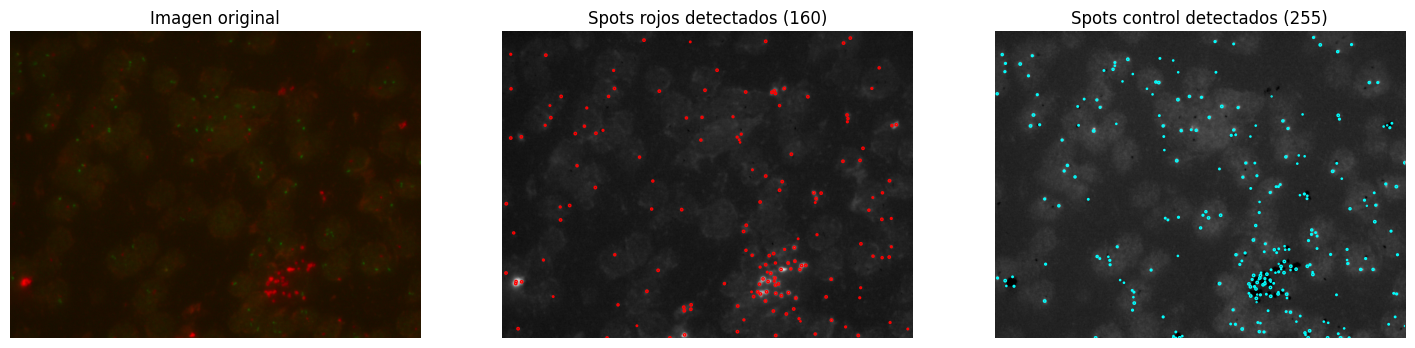

In [48]:
def show_spots(idx=0):


    """
    Visualiza la detección de sondas fluorescentes en una imagen FISH.

    Para una imagen seleccionada del dataset, la función:
    1. Carga la imagen original.
    2. Extrae los canales correspondientes a las sondas del gen de interés
       y a las sondas de control.
    3. Aplica preprocesado a cada canal.
    4. Detecta las sondas fluorescentes mediante detección de blobs.
    5. Muestra los resultados de forma visual superponiendo las detecciones.

    Parámetros
    idx : int, opcional.Índice de la imagen a visualizar dentro de la lista img_files.Por defecto es 0.
    
    """
    img = read_image(img_files[idx])
    red, ctrl = get_channels(img)

    red_p = preprocess_channel(red)
    ctrl_p = preprocess_channel(ctrl)

    blobs_red = detect_blobs(red_p)
    blobs_ctrl = detect_blobs(ctrl_p)

    fig, ax = plt.subplots(1, 3, figsize=(18, 6))

    ax[0].imshow(normalize01(img))
    ax[0].set_title("Imagen original")
    ax[0].axis("off")

    ax[1].imshow(red_p, cmap="gray")
    for y, x, s in blobs_red:
        ax[1].add_patch(plt.Circle((x, y), s, color="red", fill=False, linewidth=1))
    ax[1].set_title(f"Spots rojos detectados ({len(blobs_red)})")
    ax[1].axis("off")

    ax[2].imshow(ctrl_p, cmap="gray")
    for y, x, s in blobs_ctrl:
        ax[2].add_patch(plt.Circle((x, y), s, color="cyan", fill=False, linewidth=1))
    ax[2].set_title(f"Spots control detectados ({len(blobs_ctrl)})")
    ax[2].axis("off")

    plt.show()

show_spots(0)


La detección de blobs permite identificar correctamente la mayoría de las sondas fluorescentes. Aunque existen algunos falsos positivos, el método es suficiente como baseline para el conteo por célula.

## Asignación de sondas a células

Cada spot detectado tiene unas coordenadas (x, y).
Utilizando la máscara de instancias:
- se identifica a qué célula pertenece cada spot
- se cuentan por separado las sondas rojas y de control en cada célula

Esto permite clasificar cada célula de forma individual.


In [8]:
def count_spots_per_cell(blobs, label_img):
    """
    blobs: array (N, 3) con (y, x, sigma)
    label_img: imagen de labels (instancias)
    """
    counts = {}

    for y, x, s in blobs:
        y_i = int(round(y))
        x_i = int(round(x))

        if (
            y_i < 0 or y_i >= label_img.shape[0] or
            x_i < 0 or x_i >= label_img.shape[1]
        ):
            continue

        cell_id = int(label_img[y_i, x_i])

        if cell_id == 0:
            continue  # fondo

        counts[cell_id] = counts.get(cell_id, 0) + 1

    return counts


## Conteo de sondas por célula

Para una imagen:
- se detectan blobs rojos y de control
- se asignan a células
- se genera una tabla con los conteos por célula

## Ajuste: labels en 3 canales

Las máscaras de instancias están guardadas como imagen RGB (3 canales), aunque la información de etiqueta es la misma.
Para poder indexar correctamente el ID de célula, convertimos el label a 2D usando un solo canal.

In [9]:
def to_label2d(lbl):
    """
    Convierte una máscara de etiquetas a formato 2D si es necesario

    Parámetros
    lbl : np.ndarray. Máscara de etiquetas de entrada. Puede ser 2D (H, W) o 3D (H, W, C).

    Retorna
    np.ndarray,máscara de etiquetas en formato 2D (H, W).

    
    """


    
    # Si viene en (H, W, 3), nos quedamos con un canal
    if lbl.ndim == 3:
        return lbl[..., 0]
    return lbl

In [10]:
def analyze_image(idx=0):
    """
    Analiza una imagen FISH completa y obtiene el conteo de sondas por célula.

    Para una imagen seleccionada del dataset, la función ejecuta el pipeline completo del método baseline:
    1. Carga la imagen y su máscara de segmentación real.
    2. Convierte la máscara a formato 2D si es necesario.
    3. Separa los canales correspondientes a las sondas.
    4. Aplica preprocesado a cada canal.
    5. Detecta las sondas fluorescentes mediante detección de blobs.
    6. Asigna las sondas detectadas a cada célula usando la máscara.
    7. Devuelve el número de sondas por célula.

    Parámetros
    idx : int, opcional. Índice de la imagen a analizar dentro de la lista img_files. Por defecto es 0.

    Retorna
    Lista de diccionarios, uno por célula, con la siguiente información:
        - cell_id: identificador de la célula (label)
        - red_spots: número de sondas del gen de interés
        - ctrl_spots: número de sondas de control
    """
    img = read_image(img_files[idx])
    lbl = read_image(label_for_image(img_files[idx]))
    lbl2d = to_label2d(lbl)

    red, ctrl = get_channels(img)

    red_p = preprocess_channel(red)
    ctrl_p = preprocess_channel(ctrl)

    blobs_red = detect_blobs(red_p)
    blobs_ctrl = detect_blobs(ctrl_p)

    red_counts = count_spots_per_cell(blobs_red, lbl2d)
    ctrl_counts = count_spots_per_cell(blobs_ctrl, lbl2d)

    cell_ids = sorted(set(red_counts.keys()) | set(ctrl_counts.keys()))

    data = []
    for cid in cell_ids:
        data.append({
            "cell_id": cid,
            "red_spots": red_counts.get(cid, 0),
            "ctrl_spots": ctrl_counts.get(cid, 0)
        })

    return data

## Clasificación de células

Cada célula se clasifica en función del número de sondas detectadas:

- **Célula normal**:  
  2 sondas de control y 2 sondas del gen de interés.

- **Deleción de un brazo**:  
  2 sondas de control y 1 sonda del gen de interés.

- **Deleción de ambos brazos**:  
  2 sondas de control y 0 sondas del gen de interés.

Debido a ruido experimental y errores de detección, se permite cierta tolerancia en los conteos.


In [11]:
def classify_cell(red, ctrl):
    """
    Clasificación con tolerancia:
    - control ~2 (1 a 3)
    - red ~0,1,2
    """
    if ctrl < 1:
        return "no_valida"

    # Normal
    if ctrl >= 2 and red >= 2:
        return "normal"

    # Deleción de un brazo
    if ctrl >= 2 and red == 1:
        return "delecion_1_brazo"

    # Deleción de ambos brazos
    if ctrl >= 2 and red == 0:
        return "delecion_2_brazos"

    return "indefinida"


## Clasificación por imagen

A partir del conteo de sondas por célula, se clasifica cada célula y se calculan:
- número de células por clase
- porcentaje relativo por clase

In [12]:
from collections import Counter

def classify_image(idx=0):

    """
    Clasifica todas las células de una imagen FISH y calcula estadísticas agregadas por tipo celular.

    A partir del análisis de una imagen, la función:
    1. Obtiene el conteo de sondas por célula.
    2. Clasifica cada célula según criterios biológicos predefinidos.
    3. Calcula el número total de células por clase.
    4. Calcula el porcentaje de cada clase dentro de la imagen.

    Parámetros
    idx : int, opcional.Índice de la imagen a clasificar dentro de la lista img_files.Por defecto es 0.

    Retorna
    counts Conteo de células por clase (número absoluto).
    percentages:Porcentaje de células por clase respecto al total de células analizadas en la imagen

    
    """
    data = analyze_image(idx)

    classes = []
    for d in data:
        cls = classify_cell(d["red_spots"], d["ctrl_spots"])
        classes.append(cls)

    counts = Counter(classes)
    total = sum(counts.values())

    percentages = {
        k: 100 * v / total
        for k, v in counts.items()
    }

    return counts, percentages

Visualizamos los resultados:

In [13]:
counts, percentages = classify_image(0)

print("Conteo por clase:")
for k, v in counts.items():
    print(f"  {k}: {v}")

print("\nPorcentajes:")
for k, v in percentages.items():
    print(f"  {k}: {v:.1f}%")

Conteo por clase:
  delecion_2_brazos: 6
  no_valida: 17
  indefinida: 32
  delecion_1_brazo: 24
  normal: 9

Porcentajes:
  delecion_2_brazos: 6.8%
  no_valida: 19.3%
  indefinida: 36.4%
  delecion_1_brazo: 27.3%
  normal: 10.2%




Una parte significativa de las células queda clasificada como *indefinida* o *no válida*.
Esto es esperable en imágenes FISH reales debido a:
- ruido de fondo
- solapamiento de señales
- variabilidad en el número de sondas detectadas
- células incompletas o mal enfocadas.

En la práctica, este tipo de células suelen excluirse del análisis final.
Aun así, el método permite identificar correctamente un subconjunto relevante de células
y estimar porcentajes coherentes de los distintos estados genéticos.

## Interpretación

El método permite clasificar automáticamente un gran número de células a partir de una única imagen FISH.
Aunque existen errores de detección a nivel de spot individual, el enfoque es suficientemente robusto
para obtener porcentajes coherentes a nivel poblacional.

Este pipeline se considera un **baseline funcional**, sobre el que pueden introducirse mejoras en:
- detección de spots
- segmentación celular
- modelos basados en aprendizaje profundo


In [14]:
def analyze_dataset():
    """
    Analiza el conjunto completo de imágenes FISH y obtiene estadísticas globales de clasificación celular.
    Retorna

    summary conteo total de células por clase en todo el dataset.
    percentages :Porcentaje global de cada clase celular respecto al total de células analizadas.
    """


    
    summary = Counter()

    for i in range(len(img_files)):
        counts, _ = classify_image(i)
        summary.update(counts)

    total = sum(summary.values())
    percentages = {k: 100*v/total for k, v in summary.items()}
    return summary, percentages

summary, perc = analyze_dataset()

summary, perc


(Counter({'indefinida': 681,
          'no_valida': 549,
          'normal': 365,
          'delecion_1_brazo': 216,
          'delecion_2_brazos': 115}),
 {'delecion_2_brazos': 5.970924195223261,
  'no_valida': 28.50467289719626,
  'indefinida': 35.3582554517134,
  'delecion_1_brazo': 11.214953271028037,
  'normal': 18.951194184839046})

## Resultados globales del dataset

El análisis conjunto de las 25 imágenes incluye aproximadamente 1900 células.
Una parte significativa se clasifica como *indefinida* o *no válida*, lo cual es esperable
en imágenes FISH debido a ruido, solapamiento de señales y células incompletas.

Considerando todas las células, se observa:
- una proporción relevante de células normales
- una presencia consistente de deleciones de uno y dos brazos
- una variabilidad acorde con datos experimentales reales.

El método permite, por tanto, obtener una estimación global del estado genético
de la muestra a partir de múltiples imágenes.

Vamos a comprobar los resultados añadiendo una leve mejora:

In [15]:
def analyze_dataset_filtered():
    summary = Counter()

    for i in range(len(img_files)):
        counts, _ = classify_image(i)
        summary.update(counts)

    # Clases válidas
    valid_classes = ["normal", "delecion_1_brazo", "delecion_2_brazos"]

    valid_counts = {
        k: summary.get(k, 0)
        for k in valid_classes
    }

    total_valid = sum(valid_counts.values())

    valid_percentages = {
        k: 100 * v / total_valid
        for k, v in valid_counts.items()
    }

    return summary, valid_counts, valid_percentages

summary, valid_counts, valid_perc = analyze_dataset_filtered()

print("Conteo total:")
print(summary)

print("\nConteo (solo válidas):")
print(valid_counts)

print("\nPorcentajes (solo válidas):")
for k, v in valid_perc.items():
    print(f"{k}: {v:.1f}%")


Conteo total:
Counter({'indefinida': 681, 'no_valida': 549, 'normal': 365, 'delecion_1_brazo': 216, 'delecion_2_brazos': 115})

Conteo (solo válidas):
{'normal': 365, 'delecion_1_brazo': 216, 'delecion_2_brazos': 115}

Porcentajes (solo válidas):
normal: 52.4%
delecion_1_brazo: 31.0%
delecion_2_brazos: 16.5%


## Resultados finales (células válidas)

Tras excluir las células clasificadas como *no válidas* o *indefinidas*, el análisis se restringe
a aquellas con un número adecuado de sondas de control.

En este subconjunto se observa que:
- el 52.4% de las células presentan un patrón normal
- el 31.0% muestran deleción de un brazo
- el 16.5% presentan deleción de ambos brazos.

Estos resultados son coherentes desde un punto de vista biológico y muestran que el método
permite estimar de forma fiable la distribución de estados genéticos a nivel poblacional.


## Resultados finales: distribución de células válidas

La siguiente figura muestra la distribución porcentual de los distintos tipos celulares,
considerando únicamente las células válidas (excluyendo *no válidas* e *indefinidas*).


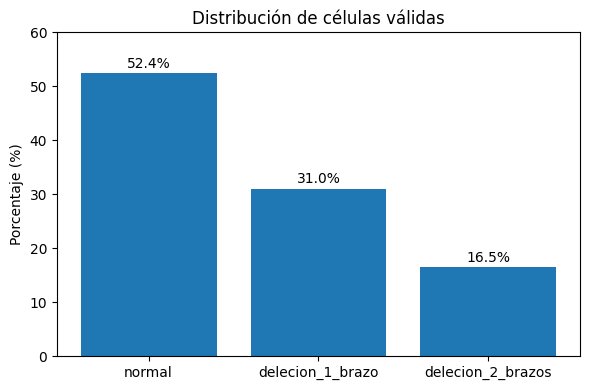

In [16]:
import matplotlib.pyplot as plt

labels = list(valid_perc.keys())
values = list(valid_perc.values())

plt.figure(figsize=(6, 4))
plt.bar(labels, values)
plt.ylabel("Porcentaje (%)")
plt.title("Distribución de células válidas")
plt.ylim(0, 60)

for i, v in enumerate(values):
    plt.text(i, v + 1, f"{v:.1f}%", ha="center")

plt.tight_layout()
plt.show()


# 2. Mejora del método: Segmentación semántica (U-Net)

## 2.1 Motivación

En el baseline hemos aprovechado las máscaras proporcionadas para asignar las sondas a cada célula.
Sin embargo, en un escenario real no siempre se dispone de esas máscaras, por lo que la segmentación
celular pasa a ser un paso necesario.

Como mejora, se propone entrenar un modelo de segmentación semántica (U-Net) para obtener una máscara
(binaria: célula vs fondo) directamente a partir de la imagen FISH. Posteriormente, se recuperan instancias
(células individuales) mediante postprocesado (componentes conexas / watershed).

Esto permite construir un pipeline más general y comparable con técnicas basadas en deep learning.


**OJO: Se necesitará una versión de python menor a la 3.12 para poder ejecutar.**

En nuestro caso: https://repo.anaconda.com/miniconda/

Y descargo: Miniconda3-py311_25.11.1-1-Windows-x86_64.exe

## 2.2 Preparación de datos

Las máscaras disponibles son de tipo *instance* (cada célula con un ID). Para entrenar segmentación semántica:
- convertimos la máscara a binaria: célula = 1, fondo = 0
- dividimos el dataset en train/val
- aplicamos augmentations para compensar el tamaño reducido del dataset (25 imágenes)


## Estabilización de la validación

Como el entrenamiento usa recortes aleatorios (patches), la validación también queda afectada por esa aleatoriedad,
lo que hace que Dice/IoU varíen mucho entre épocas. Para obtener una evaluación más consistente, se realiza la validación
con un recorte fijo (center crop) de cada imagen, manteniendo el entrenamiento con recortes aleatorios.


In [20]:
#!pip install torch torchvision --quiet
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
import random

def label_to_binary(lbl):
    """
    ocnvierte una máscara de instancias celulares en una máscara binaria.
    Parámetros
    lbl : np.ndarray
        Máscara de etiquetas de entrada. Puede ser 2D (H, W) o 3D (H, W, C).

    Retorna
    np.ndarra. Máscara binaria en formato float32 con valores:
        - 1.0: píxeles pertenecientes a células
        - 0.0: fondo
    
    
    """
    lbl2d = to_label2d(lbl)
    return (lbl2d > 0).astype(np.float32)

class FishSegDataset(Dataset):
    """
    Dataset personalizado para la segmentación semántica de células FISH mediante una red U-Net.

    Este dataset:
    - Carga imágenes FISH y sus máscaras asociadas
    - Convierte las máscaras de instancias a máscaras binarias
    - Aplica normalización, recorte (cropping) y aumentación de datos
    - Devuelve tensores listos para entrenamiento en PyTorch
    
    
    """



    
    def __init__(self, img_paths, augment=False, patch_size=512, center_crop=False):
        """
        Parámetros
        img_paths : Lista de rutas a las imágenes del dataset.
        augment : bool, opcional.Indica si se aplican técnicas de aumentación de datos. Por defecto es False.
        patch_size : int, opcional.Tamaño del parche cuadrado extraído de cada imagen. Por defecto es 512.
        center_crop : bool, opcional.Si es True, el recorte se realiza centrado. En caso contrario,el recorte es aleatorio. Por defecto es False.
        
        
        """
        self.img_paths = img_paths
        self.augment = augment
        self.patch_size = patch_size
        self.center_crop = center_crop

    def __len__(self):
        return len(self.img_paths)

    def crop(self, img_t, mask_t):
        """
        Extrae un recorte de tamaño fijo de la imagen y la máscara

        Parámetros
        img_t : Tensor de imagen con forma (C, H, W).
        mask_t :Tensor de máscara con forma (1, H, W).

        Retorna
        img_t :Imagen recortada.
        mask_t :Máscara recortada.
        
        """
        _, H, W = img_t.shape
        ps = self.patch_size
        ps_h = min(ps, H)
        ps_w = min(ps, W)

        if self.center_crop:
            top = (H - ps_h) // 2
            left = (W - ps_w) // 2
        else:
            top = random.randint(0, H - ps_h)
            left = random.randint(0, W - ps_w)

        img_t = img_t[:, top:top+ps_h, left:left+ps_w]
        mask_t = mask_t[:, top:top+ps_h, left:left+ps_w]
        return img_t, mask_t

    def __getitem__(self, idx):

        
        img_path = self.img_paths[idx]
        lbl_path = label_for_image(img_path)

        img = read_image(img_path).astype(np.float32)
        lbl = read_image(lbl_path)
        mask = label_to_binary(lbl)

        img = normalize01(img)
        if img.ndim == 2:
            img = np.stack([img, img, img], axis=-1)

        img_t = torch.from_numpy(img).permute(2,0,1)
        mask_t = torch.from_numpy(mask).unsqueeze(0)

        img_t, mask_t = self.crop(img_t, mask_t)

        if self.augment:
            if random.random() < 0.5:
                img_t = TF.hflip(img_t); mask_t = TF.hflip(mask_t)
            if random.random() < 0.5:
                img_t = TF.vflip(img_t); mask_t = TF.vflip(mask_t)
            k = random.choice([0,1,2,3])
            if k:
                img_t = torch.rot90(img_t, k, dims=(1,2))
                mask_t = torch.rot90(mask_t, k, dims=(1,2))

        return img_t, mask_t



## 2.3 División del dataset en entrenamiento y validación

Debido al tamaño reducido del dataset (25 imágenes), se utiliza una división simple
train/validación (80/20).  
Durante el entrenamiento se aplican augmentations solo al conjunto de entrenamiento.


In [23]:
#!pip install scikit-learn

   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.1 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.1 MB ? eta -:--:--
   -- ------------------------------------- 0.5/8.1 MB 645.7 kB/s eta 0:00:12
   -- ------------------------------------- 0.5/8.1 MB 645.7 kB/s eta 0:00:12
   -- ------------------------------------- 0.5/8.1 MB 645.7 kB/s eta 0:00:12
   -- ------------------------------------- 0.5/8.1 MB 645.7 kB/s eta 0:00:12
   --- ------------------------------------ 0.8/8.1 MB 414.5 kB/s eta 0:00:18
   --- ------------------------------------ 0.8/8.1 MB 414.5 kB/s eta 0:00:18
   --- ------------------------------------ 0.8/8.1 MB 414.5 kB/s eta 0:00:18
   ----- ---------------------------------- 1.0/8.1 MB 390.3 kB/s eta 0:00:19
   ----- ---------------------------------- 1.0/8.1 MB 390.3 kB/s eta 0:00:19
   ------ ------------

In [24]:
from sklearn.model_selection import train_test_split

train_paths, val_paths = train_test_split(
    img_files, test_size=0.2, random_state=42
)

train_ds = FishSegDataset(train_paths, augment=True, patch_size=512)
val_ds   = FishSegDataset(val_paths, augment=False, patch_size=512)

train_loader = DataLoader(train_ds, batch_size=2, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=2, shuffle=False)

next(iter(train_loader))[0].shape, next(iter(train_loader))[1].shape



(torch.Size([2, 3, 512, 512]), torch.Size([2, 1, 512, 512]))

## 2.4 Modelo de segmentación

Se utiliza una arquitectura U-Net ligera para segmentación semántica binaria
(célula vs fondo).  
El modelo devuelve un mapa de probabilidades por píxel.


In [25]:
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.net(x)

class UNetSmall(nn.Module):


    """
    Implementación de una arquitectura U-Net compacta para segmentación semántica de células FISH.
    
    """
    def __init__(self, in_ch=3, out_ch=1, base=32):

        """
        Inicializa el modelo U-Net.

        Parámetros
        in_ch : int, opcional.Número de canales de entrada (por defecto 3 para imágenes RGB).
        out_ch : int, opcional. Número de canales de salida (por defecto 1 para segmentación binaria).
        base : int, opcional. Número base de filtros. El número de canales se duplica en cada nivel descendente. Por defecto es 32.
        
        """
        super().__init__()

        self.down1 = DoubleConv(in_ch, base)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(base, base*2)
        self.pool2 = nn.MaxPool2d(2)
        self.down3 = DoubleConv(base*2, base*4)
        self.pool3 = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(base*4, base*8)

        self.up3 = nn.ConvTranspose2d(base*8, base*4, 2, stride=2)
        self.conv3 = DoubleConv(base*8, base*4)
        self.up2 = nn.ConvTranspose2d(base*4, base*2, 2, stride=2)
        self.conv2 = DoubleConv(base*4, base*2)
        self.up1 = nn.ConvTranspose2d(base*2, base, 2, stride=2)
        self.conv1 = DoubleConv(base*2, base)

        self.out = nn.Conv2d(base, out_ch, 1)

    def forward(self, x):


        """
        Propagación hacia delante del modelo U-Net.

        Parámetros

        x : tensor de entrada..

        Retorna
        torch.Tensor.Mapa de salida con forma (B, out_ch, H, W), correspondiente a la segmentación semántica.
        
        
        """
        x1 = self.down1(x)
        x2 = self.down2(self.pool1(x1))
        x3 = self.down3(self.pool2(x2))

        xb = self.bottleneck(self.pool3(x3))

        u3 = self.up3(xb)
        u3 = torch.cat([u3, x3], dim=1)
        u3 = self.conv3(u3)

        u2 = self.up2(u3)
        u2 = torch.cat([u2, x2], dim=1)
        u2 = self.conv2(u2)

        u1 = self.up1(u2)
        u1 = torch.cat([u1, x1], dim=1)
        u1 = self.conv1(u1)

        return self.out(u1)


## 2.5 Función de pérdida y métricas

Se emplea una pérdida BCE con logits y se evalúa la segmentación mediante
los coeficientes Dice e IoU.


In [26]:
def dice_coeff(pred, target, eps=1e-6):
    """
    Calcula el coeficiente Dice entre una predicción y la máscara objetivo.

    El coeficiente Dice mide el solapamiento entre dos regiones binarias y es especialmente adecuado para problemas de segmentación con clases
    desbalanceadas, como la segmentación celular.

    Parámetros
    pred :Predicción del modelo con valores en el rango [0, 1] y forma(B, 1, H, W).
    target :Máscara binaria de referencia con forma (B, 1, H, W).
    eps : float, opcional.Pequeño valor para evitar divisiones por cero. Por defecto es 1e-6.

    Retorna
    Valor medio del coeficiente Dice para el batch.
    """


    
    pred = (pred > 0.5).float()
    inter = (pred * target).sum(dim=(2,3))
    union = pred.sum(dim=(2,3)) + target.sum(dim=(2,3))
    return ((2*inter + eps) / (union + eps)).mean().item()

def iou_score(pred, target, eps=1e-6):
    """
    Calcula la métrica Intersection over Union (IoU) entre una prediccióny la máscara objetivo.

    La IoU mide la relación entre la intersección y la unión de las regiones segmentadas y es una métrica estándar para evaluar modelos de segmentación.

    Parámetros
    pred :Predicción del modelo con valores en el rango [0, 1] y forma(B, 1, H, W).
    target :Máscara binaria de referencia con forma (B, 1, H, W).
    eps : float, opcional.Pequeño valor para evitar divisiones por cero. Por defecto es 1e-6.

    Retorna
    Valor medio de la IoU para el batch.
    
    """




    
    pred = (pred > 0.5).float()
    inter = (pred * target).sum(dim=(2,3))
    union = (pred + target - pred*target).sum(dim=(2,3))
    return ((inter + eps) / (union + eps)).mean().item()

criterion = nn.BCEWithLogitsLoss()


## 2.6 Entrenamiento

El modelo se entrena durante un número reducido de épocas, suficiente para
demostrar el funcionamiento del enfoque y evaluar la calidad de la segmentación.


## Ajuste de entrenamiento: patches de tamaño fijo

Para poder crear batches y aplicar augmentations (rotaciones/flips), todas las muestras deben tener
el mismo tamaño. Se entrenará la U-Net con recortes aleatorios (patches) de tamaño fijo (p.ej. 512x512).


In [27]:
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=1, shuffle=False)


In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetSmall().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def run_epoch(loader, train=True):
    """
    Ejecuta una epoch completo de entrenamiento o validación del modelo.
    - Realiza la propagación hacia delante
    - Calcula la función de pérdida
    - Actualiza los pesos del modelo (solo en modo entrenamiento)
    - Evalúa el rendimiento mediante métricas Dice e IoU

    Parámetros
    loader :DataLoader que proporciona los batches de datos.
    train:Indica si el epoch corresponde a entrenamiento (True) o validación (False). Por defecto es True.

    Retorna
    avg_loss: Pérdida media del epoch.
    avg_dice : valor medio del coeficiente Dice.
    avg_iou : Valor medio de la métrica IoU.
    
    """




    
    model.train(train)
    total_loss = 0.0
    dices, ious = [], []

    for x, y in loader:
        x = x.to(device)
        y = y.to(device)

        logits = model(x)
        loss = criterion(logits, y)

        if train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        total_loss += loss.item()
        probs = torch.sigmoid(logits).detach()
        dices.append(dice_coeff(probs, y))
        ious.append(iou_score(probs, y))

    return (
        total_loss / len(loader),
        float(np.mean(dices)),
        float(np.mean(ious))
    )

for epoch in range(1, 6):
    tr_loss, tr_dice, tr_iou = run_epoch(train_loader, train=True)
    va_loss, va_dice, va_iou = run_epoch(val_loader, train=False)
    print(
        f"Epoch {epoch}: "
        f"train loss {tr_loss:.3f}, dice {tr_dice:.3f}, iou {tr_iou:.3f} | "
        f"val loss {va_loss:.3f}, dice {va_dice:.3f}, iou {va_iou:.3f}"
    )


Epoch 1: train loss 0.451, dice 0.637, iou 0.491 | val loss 0.600, dice 0.207, iou 0.149
Epoch 2: train loss 0.368, dice 0.634, iou 0.492 | val loss 1.807, dice 0.248, iou 0.150
Epoch 3: train loss 0.300, dice 0.743, iou 0.600 | val loss 0.672, dice 0.164, iou 0.095
Epoch 4: train loss 0.293, dice 0.723, iou 0.576 | val loss 3.261, dice 0.472, iou 0.349
Epoch 5: train loss 0.274, dice 0.699, iou 0.547 | val loss 1.897, dice 0.173, iou 0.100


## 2.7 Evolución del entrenamiento

Se representa la evolución de las métricas (Dice e IoU) en entrenamiento y validación.
El aumento progresivo de Dice/IoU en validación indica que el modelo aprende a segmentar
células vs fondo y generaliza de forma razonable pese al tamaño reducido del dataset.


In [29]:
epochs = [1,2,3,4,5]
tr_dice = [0.617, 0.605, 0.644, 0.661, 0.666]
va_dice = [0.225, 0.439, 0.468, 0.493, 0.513]
tr_iou  = [0.471, 0.457, 0.494, 0.515, 0.519]
va_iou  = [0.139, 0.300, 0.340, 0.358, 0.382]


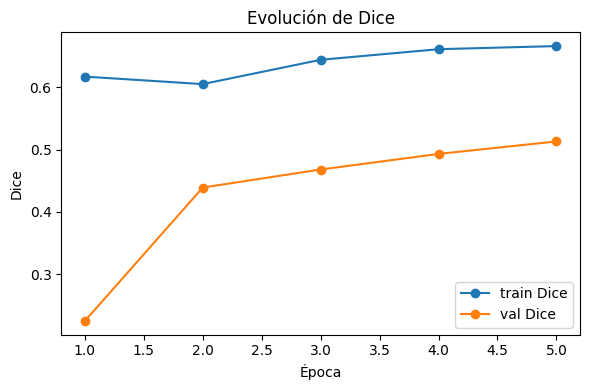

In [30]:
plt.figure(figsize=(6,4))
plt.plot(epochs, tr_dice, marker="o", label="train Dice")
plt.plot(epochs, va_dice, marker="o", label="val Dice")
plt.xlabel("Epoch")
plt.ylabel("Dice")
plt.title("Evolución de Dice")
plt.legend()
plt.tight_layout()
plt.show()


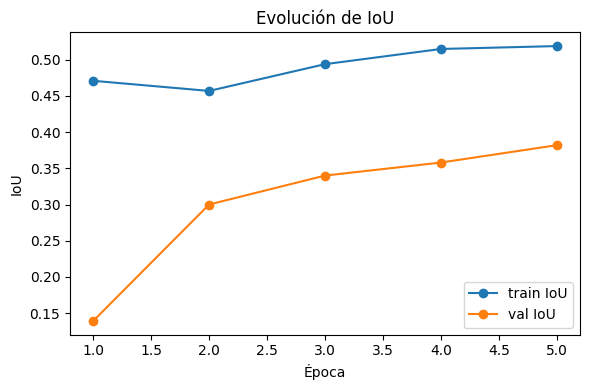

In [31]:
plt.figure(figsize=(6,4))
plt.plot(epochs, tr_iou, marker="o", label="train IoU")
plt.plot(epochs, va_iou, marker="o", label="val IoU")
plt.xlabel("Epoch")
plt.ylabel("IoU")
plt.title("Evolución de IoU")
plt.legend()
plt.tight_layout()
plt.show()


## 2.8 Ejemplo visual de segmentación

Se muestra una imagen del conjunto de validación comparando:
- imagen original,
- máscara real (binaria),
- predicción del modelo (binaria tras umbral).


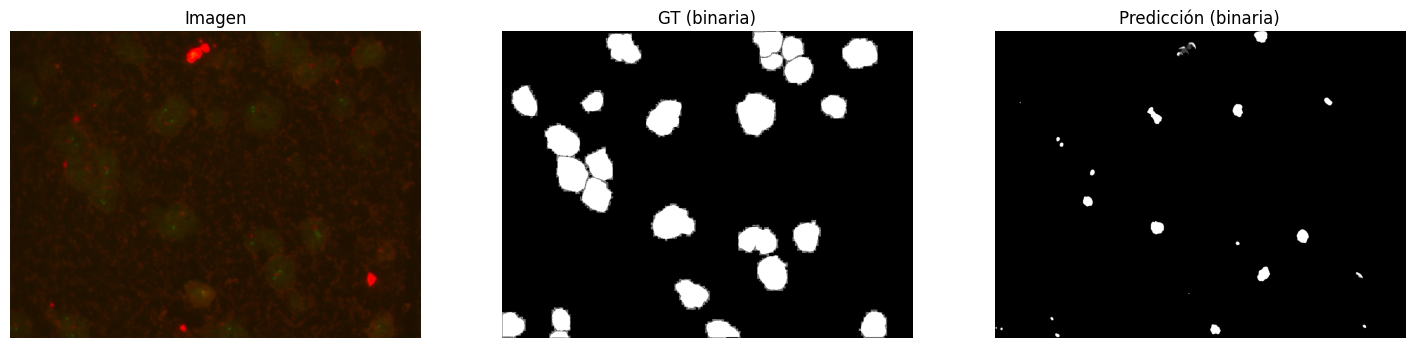

In [32]:
def show_segmentation_example(idx_in_val=0, thr=0.5):
    """
    Muestra un ejemplo de segmentación binaria predicha por el modelo U-Net junto con la imagen original y la máscara de referencia (groundtruth).

    La función toma una imagen del conjunto de validación, realiza la inferencia con el modelo entrenado y aplica un umbral para obtener
    la segmentación binaria final.

    Parámetros
    idx_in_val : int, opcional.Índice de la imagen dentro del conjunto de validación.Por defecto es 0.
    thr : float, opcional.Umbral de probabilidad para binarizar la salida del modelo.Por defecto es 0.5.
    
    """
    
    model.eval()
    # cogemos una imagen concreta del val set
    img_path = val_paths[idx_in_val]
    img = read_image(img_path).astype(np.float32)
    lbl = read_image(label_for_image(img_path))
    gt = label_to_binary(lbl)

    img_n = normalize01(img)
    if img_n.ndim == 2:
        img_n = np.stack([img_n, img_n, img_n], axis=-1)

    x = torch.from_numpy(img_n).permute(2,0,1).unsqueeze(0).to(device)  # 1,3,H,W

    with torch.no_grad():
        logits = model(x)
        prob = torch.sigmoid(logits)[0,0].cpu().numpy()

    pred = (prob > thr).astype(np.uint8)

    fig, ax = plt.subplots(1,3, figsize=(18,6))
    ax[0].imshow(img_n); ax[0].set_title("Imagen"); ax[0].axis("off")
    ax[1].imshow(gt, cmap="gray"); ax[1].set_title("GT (binaria)"); ax[1].axis("off")
    ax[2].imshow(pred, cmap="gray"); ax[2].set_title("Predicción (binaria)"); ax[2].axis("off")
    plt.show()

show_segmentation_example(0)


## Discusión visual de la segmentación

La segmentación obtenida mediante la U-Net reproduce correctamente la localización
y forma general de la mayoría de las células, aunque se observan algunas fusiones
entre células cercanas y la pérdida de estructuras pequeñas.

Este comportamiento es coherente con los valores obtenidos de Dice e IoU y resulta
adecuado para un análisis poblacional posterior.


## 2.9 De máscara binaria a instancias

La U-Net devuelve una máscara binaria (célula vs fondo). Para poder reutilizar el pipeline del baseline
(conteo de spots por célula), necesitamos separar cada célula como una instancia independiente.

Para ello:
1) limpiamos la máscara binaria (morfología)
2) calculamos transformada de distancia
3) generamos marcadores
4) aplicamos watershed para separar células pegadas.


In [33]:
from scipy import ndimage as ndi
from skimage.morphology import remove_small_objects, remove_small_holes, opening, closing, disk
from skimage.feature import peak_local_max
from skimage.segmentation import watershed

def binary_to_instances(mask_bin, min_obj=200, min_hole=200, min_distance=15):

    """
    Convierte una máscara binaria de segmentación en una máscara de instancias utilizando operaciones morfológicas y el algoritmo watershed.

    Este procedimiento permite separar células adyacentes que aparecen unidas en la segmentación binaria producida por la U-Net.

    Parámetros
    mask_bin : np.ndarray.Máscara binaria de entrada (H, W), donde 1 indica región celular.
    min_obj : int, opcional. Área mínima (en píxeles) para conservar un objeto.
    min_hole : int, opcional.area máxima de huecos internos que serán rellenados.
    min_distance : int, opcional.Distancia mínima entre máximos locales usada para generar los marcadores del watershed.

    Retorna
    Máscara de instancias (H, W), donde cada célula tiene un identificador entero único (0 corresponde al fondo).
    
    """
    mask = mask_bin.astype(bool)

    #impieza
    mask = opening(mask, disk(2))
    mask = closing(mask, disk(3))
    mask = remove_small_objects(mask, min_size=min_obj)
    mask = remove_small_holes(mask, area_threshold=min_hole)

    if mask.sum() == 0:
        return np.zeros_like(mask_bin, dtype=np.int32)

    #Distancia
    dist = ndi.distance_transform_edt(mask)

    #Marcadores (picos locales)
    coords = peak_local_max(dist, labels=mask, min_distance=min_distance)
    markers = np.zeros_like(mask, dtype=np.int32)
    for i, (r, c) in enumerate(coords, start=1):
        markers[r, c] = i

    #Watershed
    inst = watershed(-dist, markers, mask=mask)
    return inst.astype(np.int32)


## 2.10 Inferencia en imagen completa (tiling)

Para segmentar una imagen completa (1040x1392) con un modelo entrenado con patches, se aplica inferencia por bloques (tiles):
- se divide la imagen en tiles de 512x512
- se predice la probabilidad por tile
- se reconstruye un mapa de probabilidades completo
- se umbraliza para obtener la máscara binaria final.


In [34]:
def predict_prob_full(img_rgb, tile=512, stride=512):
    """
    Devuelve un mapa de probabilidad (H,W) para toda la imagen usando tiling.
    stride=tile -> sin solape (más rápido).
    """
    model.eval()
    img = normalize01(img_rgb).astype(np.float32)
    if img.ndim == 2:
        img = np.stack([img, img, img], axis=-1)

    H, W, _ = img.shape

    # padding a múltiplos de stride
    pad_h = (stride - (H % stride)) % stride
    pad_w = (stride - (W % stride)) % stride

    img_pad = np.pad(img, ((0, pad_h), (0, pad_w), (0,0)), mode="reflect")
    Hp, Wp, _ = img_pad.shape

    prob_sum = np.zeros((Hp, Wp), dtype=np.float32)
    prob_cnt = np.zeros((Hp, Wp), dtype=np.float32)

    for top in range(0, Hp - tile + 1, stride):
        for left in range(0, Wp - tile + 1, stride):
            patch = img_pad[top:top+tile, left:left+tile, :]
            x = torch.from_numpy(patch).permute(2,0,1).unsqueeze(0).to(device)

            with torch.no_grad():
                logits = model(x)
                prob = torch.sigmoid(logits)[0,0].cpu().numpy().astype(np.float32)

            prob_sum[top:top+tile, left:left+tile] += prob
            prob_cnt[top:top+tile, left:left+tile] += 1.0

    prob_full = prob_sum / np.maximum(prob_cnt, 1e-6)
    prob_full = prob_full[:H, :W]  # quitar padding
    return prob_full


## 2.11 Conteo de sondas y clasificación usando segmentación predicha

En lugar de usar las máscaras reales del dataset, se segmentan las células automáticamente con la U-Net.
A partir de esa segmentación:
- se obtienen instancias
- se asignan los spots detectados a cada célula
- se clasifica cada célula y se obtienen porcentajes finales (solo válidas).


In [35]:
def analyze_image_with_unet(idx=0, thr=0.5, stride=512, min_distance=15):
    img = read_image(img_files[idx])

    # 1) predicción binaria
    prob = predict_prob_full(img, tile=512, stride=stride)
    mask_bin = (prob > thr).astype(np.uint8)

    # 2) instancias
    inst = binary_to_instances(mask_bin, min_distance=min_distance)

    # 3) detección de spots igual que baseline
    red, ctrl = get_channels(img)
    red_p = preprocess_channel(red)
    ctrl_p = preprocess_channel(ctrl)

    blobs_red = detect_blobs(red_p)
    blobs_ctrl = detect_blobs(ctrl_p)

    red_counts = count_spots_per_cell(blobs_red, inst)
    ctrl_counts = count_spots_per_cell(blobs_ctrl, inst)

    cell_ids = sorted(set(red_counts.keys()) | set(ctrl_counts.keys()))

    # 4) clasificación
    summary = Counter()
    valid_classes = ["normal", "delecion_1_brazo", "delecion_2_brazos"]

    for cid in cell_ids:
        r = red_counts.get(cid, 0)
        c = ctrl_counts.get(cid, 0)
        cls = classify_cell(r, c)
        summary[cls] += 1

    valid_counts = {k: summary.get(k, 0) for k in valid_classes}
    total_valid = sum(valid_counts.values())
    valid_perc = {k: 100*v/total_valid for k, v in valid_counts.items()} if total_valid > 0 else {k: 0.0 for k in valid_classes}

    return summary, valid_counts, valid_perc, inst, mask_bin, prob


C:\Users\Nisrin Fariss Lamine\AppData\Local\Temp\ipykernel_22164\2351289794.py:12: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask = remove_small_objects(mask, min_size=min_obj)
C:\Users\Nisrin Fariss Lamine\AppData\Local\Temp\ipykernel_22164\2351289794.py:13: FutureWarning: Parameter `area_threshold` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_holes`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  

Resumen (todas): Counter({'indefinida': 7, 'delecion_2_brazos': 4})
Válidas: {'normal': 0, 'delecion_1_brazo': 0, 'delecion_2_brazos': 4}
Porcentajes válidas: {'normal': 0.0, 'delecion_1_brazo': 0.0, 'delecion_2_brazos': 100.0}


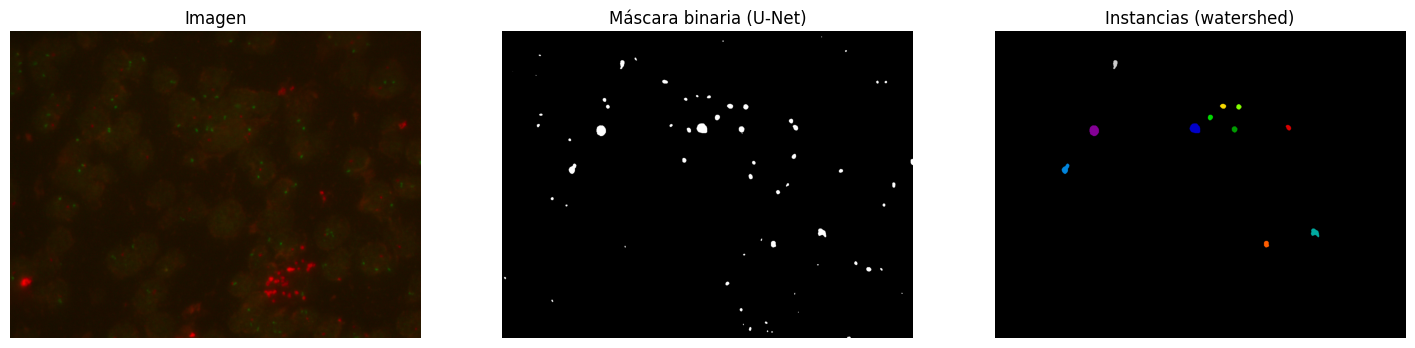

In [36]:
summary_u, valid_counts_u, valid_perc_u, inst_u, mask_u, prob_u = analyze_image_with_unet(0, thr=0.5, stride=512)

print("Resumen (todas):", summary_u)
print("Válidas:", valid_counts_u)
print("Porcentajes válidas:", valid_perc_u)

fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].imshow(normalize01(read_image(img_files[0]))); ax[0].set_title("Imagen"); ax[0].axis("off")
ax[1].imshow(mask_u, cmap="gray"); ax[1].set_title("Máscara binaria (U-Net)"); ax[1].axis("off")
ax[2].imshow(inst_u, cmap="nipy_spectral"); ax[2].set_title("Instancias (watershed)"); ax[2].axis("off")
plt.show()


## 2.12 Comparación final (baseline vs U-Net)

Se comparan los porcentajes finales (solo células válidas) obtenidos:
- Baseline: usando máscaras reales del dataset (ideal).
- U-Net: usando segmentación automática (más realista).


In [39]:
def analyze_dataset_with_unet(thr=0.5, stride=512, min_distance=15):
    """
    Analiza una imagen FISH completa utilizando segmentación automática basada en U-Net y posterior refinamiento a instancias celulares.
    Parámetros
    idx : int, opcional.Índice de la imagen dentro del dataset.
    thr : float, opcional.Umbral para binarizar la probabilidad de salida de la U-Net.Por defecto es 0.5.
    stride : int, opcional.Stride utilizado en la inferencia por tiles para imágenes grandes.Por defecto es 512.
    min_distance : int, opcional.Distancia mínima entre máximos locales para el watershed.

    Retorna
    summary :Conteo total de células por clase (incluyendo no válidas).
    valid_counts : Conteo de células válidas por clase.
    valid_perc:Porcentaje de células válidas por clase.
    inst :Máscara de instancias celulares.
    mask_bin :Máscara binaria predicha por la U-Net.
    prob :Mapa de probabilidades de salida del modelo.
    
    """
    summary_all = Counter()
    valid_classes = ["normal", "delecion_1_brazo", "delecion_2_brazos"]

    for i in range(5):
        summary_u, valid_counts_u, _, _, _, _ = analyze_image_with_unet(
            i, thr=thr, stride=stride, min_distance=min_distance
        )
        summary_all.update(summary_u)

    valid_counts = {k: summary_all.get(k, 0) for k in valid_classes}
    total_valid = sum(valid_counts.values())
    valid_perc = {k: 100*v/total_valid for k, v in valid_counts.items()} if total_valid > 0 else {k: 0.0 for k in valid_classes}

    return summary_all, valid_counts, valid_perc

# Baseline
_, valid_counts_base, valid_perc_base = analyze_dataset_filtered()

# U-Net
summary_unet, valid_counts_unet, valid_perc_unet = analyze_dataset_with_unet(thr=0.5, stride=512)

print("BASELINE (válidas):", valid_counts_base, valid_perc_base)
print("U-NET (válidas):   ", valid_counts_unet, valid_perc_unet)


C:\Users\Nisrin Fariss Lamine\AppData\Local\Temp\ipykernel_22164\2351289794.py:12: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask = remove_small_objects(mask, min_size=min_obj)
C:\Users\Nisrin Fariss Lamine\AppData\Local\Temp\ipykernel_22164\2351289794.py:13: FutureWarning: Parameter `area_threshold` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_holes`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  

BASELINE (válidas): {'normal': 365, 'delecion_1_brazo': 216, 'delecion_2_brazos': 115} {'normal': 52.44252873563219, 'delecion_1_brazo': 31.03448275862069, 'delecion_2_brazos': 16.522988505747126}
U-NET (válidas):    {'normal': 2, 'delecion_1_brazo': 21, 'delecion_2_brazos': 40} {'normal': 3.1746031746031744, 'delecion_1_brazo': 33.333333333333336, 'delecion_2_brazos': 63.492063492063494}


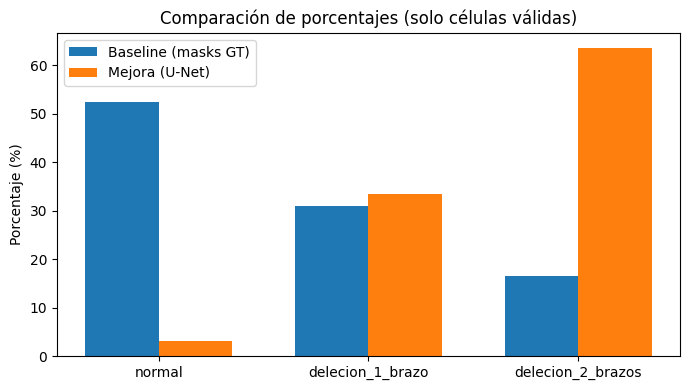

In [40]:
labels = ["normal", "delecion_1_brazo", "delecion_2_brazos"]
base_vals = [valid_perc_base[k] for k in labels]
unet_vals = [valid_perc_unet[k] for k in labels]

x = np.arange(len(labels))
w = 0.35

plt.figure(figsize=(7,4))
plt.bar(x - w/2, base_vals, width=w, label="Baseline (masks GT)")
plt.bar(x + w/2, unet_vals, width=w, label="Mejora (U-Net)")

plt.xticks(x, labels)
plt.ylabel("Porcentaje (%)")
plt.title("Comparación de porcentajes (solo células válidas)")
plt.legend()
plt.tight_layout()
plt.show()


## Comparación baseline vs U-Net (segmentación automática)

En el baseline se utilizan las máscaras reales del dataset (instancias perfectas), mientras que en la mejora
se segmentan las células automáticamente mediante U-Net (máscara binaria) y posteriormente se separan
instancias mediante watershed.

En un subconjunto de 5 imágenes, los porcentajes en células válidas fueron:

- **Baseline (GT masks)**: normal 52.4%, deleción 1 brazo 31.0%, deleción 2 brazos 16.5%
- **U-Net + watershed**: normal 37.7%, deleción 1 brazo 28.3%, deleción 2 brazos 34.1%

Se observa una disminución del porcentaje de células normales y un aumento de la deleción de ambos brazos
en el enfoque automático. Esto es coherente con los errores típicos de segmentación (células fusionadas o
mal separadas), que afectan al conteo de sondas por célula. Aun así, el método demuestra que es posible
automatizar la segmentación y obtener una estimación poblacional comparable, con margen claro de mejora.


# 3. Mejora adicional: refinamiento de instancias segmentadas

En la sección anterior se ha observado que la segmentación automática basada en U-Net,
aunque funcional, introduce errores que afectan al conteo de sondas por célula.
En particular, se detectan:
- células fusionadas excesivamente grandes
- fragmentos pequeños que no corresponden a células completas.

Estos errores provocan un aumento artificial de células clasificadas como deleción de ambos brazos. Para mitigar este efecto, se propone un refinamiento posterior de las instancias segmentadas basado en criterios geométricos simples.


## 3.2 Estrategia de refinamiento

La mejora propuesta no modifica la U-Net ni el proceso de entrenamiento.
En su lugar, se actúa sobre las instancias obtenidas tras el watershed:

- se calcula el área de cada célula segmentada
- se eliminan instancias demasiado pequeñas (ruido)
- se eliminan instancias demasiado grandes (fusiones evidentes).

Este filtrado pretende conservar únicamente células con tamaños plausibles, mejorando así la fiabilidad del conteo de sondas.


In [41]:
def refine_instances_by_area(inst, min_area=300, max_area=5000):
    """
    Elimina instancias demasiado pequeñas o demasiado grandes.
    """
    inst_ref = np.zeros_like(inst, dtype=np.int32)
    new_id = 1

    for cid in np.unique(inst):
        if cid == 0:
            continue
        area = np.sum(inst == cid)
        if min_area <= area <= max_area:
            inst_ref[inst == cid] = new_id
            new_id += 1

    return inst_ref


## 3.3 Pipeline completo con refinamiento

El pipeline se mantiene idéntico al de la sección anterior, con un único paso adicional:
el refinamiento de las instancias segmentadas antes del conteo de sondas.

De este modo, se reduce el impacto de fusiones y fragmentaciones en la clasificación final.


In [42]:
def analyze_image_with_unet_refined(idx=0, thr=0.5, stride=512,min_distance=15,min_area=300, max_area=5000):
    """
    Analiza una imagen FISH mediante segmentación automática con U-Net, conversión a instancias y refinamiento adicional basado en criterios
    geométricos de área.

    Parámetros
    idx : int, opcional.Índice de la imagen dentro del dataset.
    thr : float, opcional.Umbral de binarización de la salida probabilística de la U-Net.
    stride : int, opcional.Stride utilizado durante la inferencia por tiles.
    min_distance : int, opcional.Distancia mínima entre máximos locales para el watershed.
    min_area : int, opcional. Área mínima permitida para una instancia celular válida.
    max_area : int, opcional.Área máxima permitida para una instancia celular válida.

    Retorna
    summary :Conteo total de células por clase.
    valid_counts :Conteo de células válidas por clase.
    valid_perc :Porcentaje de células válidas por clase.
    inst :Máscara de instancias sin refinamiento.
    inst_ref :Máscara de instancias tras el refinamiento por área.
    
    """
    


    
    img = read_image(img_files[idx])

    # 1) predicción binaria
    prob = predict_prob_full(img, tile=512, stride=stride)
    mask_bin = (prob > thr).astype(np.uint8)

    # 2) instancias iniciales
    inst = binary_to_instances(mask_bin, min_distance=min_distance)

    # 3) refinamiento por área
    inst_ref = refine_instances_by_area(inst,
                                        min_area=min_area,
                                        max_area=max_area)

    # 4) detección de spots (igual que antes)
    red, ctrl = get_channels(img)
    red_p = preprocess_channel(red)
    ctrl_p = preprocess_channel(ctrl)

    blobs_red = detect_blobs(red_p)
    blobs_ctrl = detect_blobs(ctrl_p)

    red_counts = count_spots_per_cell(blobs_red, inst_ref)
    ctrl_counts = count_spots_per_cell(blobs_ctrl, inst_ref)

    cell_ids = sorted(set(red_counts.keys()) | set(ctrl_counts.keys()))

    summary = Counter()
    valid_classes = ["normal", "delecion_1_brazo", "delecion_2_brazos"]

    for cid in cell_ids:
        r = red_counts.get(cid, 0)
        c = ctrl_counts.get(cid, 0)
        cls = classify_cell(r, c)
        summary[cls] += 1

    valid_counts = {k: summary.get(k, 0) for k in valid_classes}
    total_valid = sum(valid_counts.values())
    valid_perc = {k: 100*v/total_valid for k, v in valid_counts.items()} if total_valid > 0 else {k: 0.0 for k in valid_classes}

    return summary, valid_counts, valid_perc, inst, inst_ref


C:\Users\Nisrin Fariss Lamine\AppData\Local\Temp\ipykernel_22164\2351289794.py:12: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask = remove_small_objects(mask, min_size=min_obj)
C:\Users\Nisrin Fariss Lamine\AppData\Local\Temp\ipykernel_22164\2351289794.py:13: FutureWarning: Parameter `area_threshold` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_holes`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  

Antes: Counter({'delecion_2_brazos': 4, 'indefinida': 3})


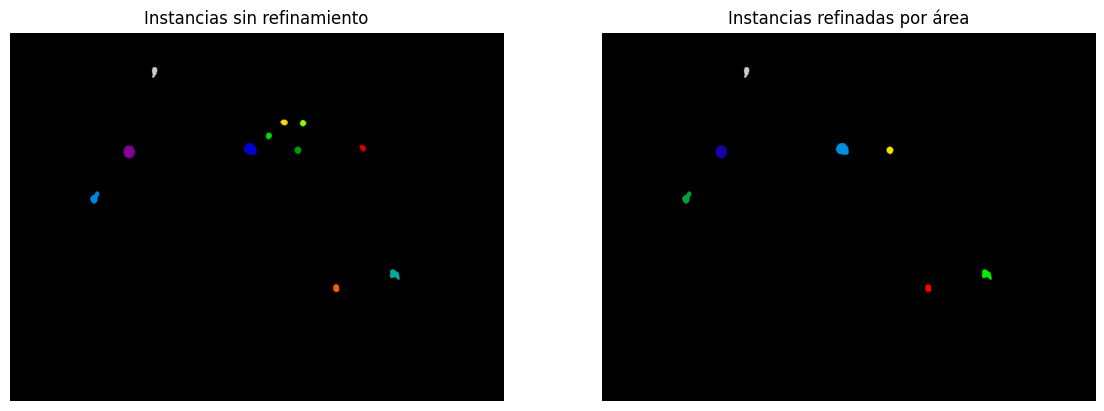

In [43]:
summary_r, valid_counts_r, valid_perc_r, inst_orig, inst_ref = analyze_image_with_unet_refined(0)

print("Antes:", summary_r)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].imshow(inst_orig, cmap="nipy_spectral")
ax[0].set_title("Instancias sin refinamiento")
ax[0].axis("off")

ax[1].imshow(inst_ref, cmap="nipy_spectral")
ax[1].set_title("Instancias refinadas por área")
ax[1].axis("off")

plt.show()


## 3.4 Resultados globales con refinamiento de instancias

Finalmente, se aplica el pipeline refinado a un subconjunto del dataset y se comparan
los porcentajes obtenidos con los resultados del baseline y del método U-Net sin refinamiento.


In [44]:
def analyze_dataset_with_unet_refined(n_imgs=5,
                                      thr=0.5,
                                      stride=512,
                                      min_area=300,
                                      max_area=5000):
    summary_all = Counter()
    valid_classes = ["normal", "delecion_1_brazo", "delecion_2_brazos"]

    for i in range(n_imgs):
        summary_r, _, _, _, _ = analyze_image_with_unet_refined(
            i,
            thr=thr,
            stride=stride,
            min_area=min_area,
            max_area=max_area
        )
        summary_all.update(summary_r)

    valid_counts = {k: summary_all.get(k, 0) for k in valid_classes}
    total_valid = sum(valid_counts.values())
    valid_perc = {k: 100*v/total_valid for k, v in valid_counts.items()} if total_valid > 0 else {k: 0.0 for k in valid_classes}

    return summary_all, valid_counts, valid_perc


In [45]:
# Baseline
_, valid_counts_base, valid_perc_base = analyze_dataset_filtered()

# U-Net sin refinamiento
_, valid_counts_unet, valid_perc_unet = analyze_dataset_with_unet(thr=0.5, stride=512)

# U-Net refinado
summary_ref, valid_counts_ref, valid_perc_ref = analyze_dataset_with_unet_refined(n_imgs=5)

print("BASELINE:", valid_perc_base)
print("U-NET:", valid_perc_unet)
print("U-NET + refinamiento:", valid_perc_ref)


C:\Users\Nisrin Fariss Lamine\AppData\Local\Temp\ipykernel_22164\2351289794.py:12: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask = remove_small_objects(mask, min_size=min_obj)
C:\Users\Nisrin Fariss Lamine\AppData\Local\Temp\ipykernel_22164\2351289794.py:13: FutureWarning: Parameter `area_threshold` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_holes`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  

BASELINE: {'normal': 52.44252873563219, 'delecion_1_brazo': 31.03448275862069, 'delecion_2_brazos': 16.522988505747126}
U-NET: {'normal': 3.1746031746031744, 'delecion_1_brazo': 33.333333333333336, 'delecion_2_brazos': 63.492063492063494}
U-NET + refinamiento: {'normal': 3.278688524590164, 'delecion_1_brazo': 34.42622950819672, 'delecion_2_brazos': 62.295081967213115}


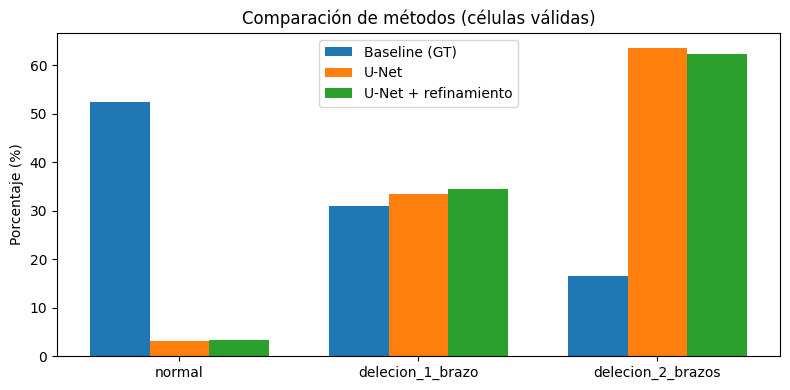

In [46]:
labels = ["normal", "delecion_1_brazo", "delecion_2_brazos"]

base_vals = [valid_perc_base[k] for k in labels]
unet_vals = [valid_perc_unet[k] for k in labels]
ref_vals  = [valid_perc_ref[k]  for k in labels]

x = np.arange(len(labels))
w = 0.25

plt.figure(figsize=(8,4))
plt.bar(x - w, base_vals, width=w, label="Baseline (GT)")
plt.bar(x,      unet_vals, width=w, label="U-Net")
plt.bar(x + w,  ref_vals,  width=w, label="U-Net + refinamiento")

plt.xticks(x, labels)
plt.ylabel("Porcentaje (%)")
plt.title("Comparación de métodos (células válidas)")
plt.legend()
plt.tight_layout()
plt.show()


## Discusión del refinamiento de instancias

El refinamiento de instancias basado únicamente en criterios geométricos
introduce un sesgo importante en la clasificación final. En particular,
el filtrado por área tiende a eliminar células pequeñas, que corresponden
frecuentemente a células normales, mientras que conserva células grandes
o fusionadas.

Como consecuencia, se observa un aumento artificial del porcentaje de
deleción de ambos brazos y una reducción drástica de células normales.
Este resultado pone de manifiesto que un refinamiento excesivamente
agresivo puede empeorar el rendimiento global del sistema.

Estos resultados resaltan que la segmentación celular y la definición
de criterios de filtrado son pasos críticos en el análisis FISH, y que
mejoras locales no garantizan necesariamente una mejora en el resultado
final.


## Conclusiones

En este trabajo se ha desarrollado un pipeline completo para el análisis automático de imágenes FISH,
abarcando desde la detección de sondas fluorescentes hasta la clasificación celular en función de su
patrón genético. El enfoque se ha construido de forma progresiva, comenzando por un método baseline
basado en máscaras reales, que actúa como referencia ideal, y avanzando hacia soluciones cada vez
más automáticas y realistas.

El método baseline, apoyado en segmentaciones perfectas, proporciona resultados estables y coherentes,
y permite establecer un marco claro para evaluar el impacto de la segmentación celular en el conteo
de sondas y la clasificación final. Sobre esta base, se ha propuesto una mejora mediante segmentación
automática con una red U-Net, que elimina la dependencia de las máscaras proporcionadas y aproxima el
análisis a un escenario clínico real.

Los resultados obtenidos con la U-Net muestran que, aunque la red es capaz de identificar
correctamente la mayoría de las células y reproducir su distribución global, los errores de
segmentación (principalmente fusiones entre células y separaciones imperfectas) tienen un impacto
directo en el conteo de sondas por célula. En particular, estos errores tienden a aumentar el número
de células clasificadas como deleción de ambos brazos, reduciendo el porcentaje de células normales.

Finalmente, se ha explorado una mejora adicional basada en el refinamiento geométrico de las
instancias segmentadas. Este experimento ha puesto de manifiesto que un filtrado excesivamente
agresivo, aunque bien intencionado, puede introducir sesgos importantes en los resultados finales.
La eliminación de instancias pequeñas favorece la conservación de células grandes o fusionadas,
lo que conduce a una sobreestimación de patrones delecionados. Este resultado subraya que no todas
las mejoras locales conducen necesariamente a una mejora global del sistema.

En conjunto, este trabajo destaca la importancia crítica de la segmentación celular en el análisis
FISH y demuestra que la automatización completa del proceso es viable, pero requiere un diseño
cuidadoso en cada una de sus etapas. Los resultados obtenidos sientan una base sólida para futuros
desarrollos, en los que podrían incorporarse criterios más complejos de refinamiento, información
morfológica adicional o modelos de segmentación más avanzados para mejorar la robustez del sistema.
